# **Exploring Hurricane Tracks**

In this notebook, we reproduce some of the analysis carried out in "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al.

This notebook (a Python-based JupyterNotebook) provides a set of starter codes for [LEAP CPC Spring 2025](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges) [**Project 1**](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges#project-cycle-1-individual-notebook-for-exploratory-data-analysis) on

+ how to work with x-array data (given the hurricane tracks data),
+ how to visualize tracks and their moments,
+ how to carry out basic analysis on the hurricane data,
+ how to do k-means with the moments based on the paper's original idea.

All the codes in this notebook can be modified to implement research ideas.  



- Github sharing is recommended.
    - See our Github [tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md).
    - If you need help, please reach out to TA Xinyi Ke xk2161@columbia.edu.




# Step 0: Setup workspace

In [2]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)


Setup a subfolder for downloaded raw data and another subfolder for outputs. This prevents you from overwrites raw data by accident.

You can check that this new folder called 'data' was created. To view the files in your workspace, click on the 'File Browser' buttom at the left side-bar.

This folder will be used to store data which will be later downloaded.

---



# Step 1: Install packages, import packages and download data


## 1.1 Packages

Download the required packges.

In [3]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [4]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import pandas as pd
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

## 1.2 Load Hurricane Data

Useful links to read more about data:

* [Official website for IBTrACS](https://www.ncdc.noaa.gov/ibtracs/). (where the data comes from)

* [Tracks in other basins for IBTrACs (other than NA)](https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/) (The data downloaded below covers the tracks in the basin 'NA' (North America). So, if you want to study tracks or hurricanes from other basins, this link might be helpful.)

* Another source of data: [HURDAT2](https://oasishub.co/dataset/hurdat-2-atlantic-hurricane-database/resource/2c865c53-3fc3-4e16-9ef5-0d76a47cfcf3) (not used in this notebook, but might be useful)



*   General documentation of the data: https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf
*   Detailed documentation on each variable(this is particularly helpful if you want to dig more into the dataset and find what problems you are interested in solving regarding the track data): https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_v04_column_documentation.pdf


In [5]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [6]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

Now, check the /data directory (left panell( to see if the data `NA_data.nc` has been saved there.

# Step 2: Visualization of hurricane tracks






In this section, the notebooks give examples on how to plot tracks on a map on locations specified by users.

All the codes in this section can be directly used or modified to allow more features in later works.

## 2.1 Map background

This function plots a background map with parameters label and extent.



*   **label**: boolean, to short label or not on the output map background
*   **extent**: this controls where the projection appears, i.e., which part of earth map should appear on the projection. Its four entries can be viewd as (starting_longitude, ending_longitude, starting_latitude, ending_latitude).



In [7]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

### 2.2.1 Explore the dataset of hurricanes and related systems

In [8]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

#filter data down to 1980 to 2024 to match data in destruction dataset
storms = tks.where(tks.season > 1979)

#match the naming convention in destruction dataset
#all_names = [str(name)[2:-1] for name in storms.name.values]
#all_names

for x in range(len(storms.name.values)):
    storms.name.values[x] = str(storms.name.values[x])[2:-1]

#focus on named storms
storms_subset = storms.where(storms.name != '', drop=True)
storms_subset = storms_subset.where(storms_subset.name != 'NOT_NAMED', drop=True)

In [9]:
#loading death & destruction info
destruction_data = pd.read_csv("data/hurricane_events-US-1980-2024.csv")

#format storm naming to match NA_data format
destruction_data['NA_name'] = destruction_data.Name.str.split().str[1]
destruction_data['year'] = destruction_data['Begin Date'].astype(str).str.slice(0, 4)
for value in range(len(destruction_data.NA_name)):
    if destruction_data.NA_name[value] == 'Storm':
        destruction_data['NA_name'][value] = destruction_data.Name.str.split().str[2]
        
destruction_data['NA_name'] = destruction_data['NA_name'].str.upper()
destruction_data

,Name,Disaster,Begin Date,End Date,CPI-Adjusted Cost,Unadjusted Cost,Deaths,NA_name,year
0,Hurricane Allen (August 1980),Tropical Cyclone,19800807,19800811,2236.2,590.0,13,ALLEN,1980
1,Hurricane Alicia (August 1983),Tropical Cyclone,19830817,19830820,9450.0,3000.0,21,ALICIA,1983
2,Hurricane Elena (September 1985),Tropical Cyclone,19850830,19850903,3788.4,1297.4,4,ELENA,1985
3,Hurricane Gloria (September 1985),Tropical Cyclone,19850926,19850928,2491.3,856.1,11,GLORIA,1985
4,Hurricane Juan (October 1985),Tropical Cyclone,19851027,19851031,4340.4,1496.7,63,JUAN,1985
...,...,...,...,...,...,...,...,...,...
62,Hurricane Beryl (July 2024),Tropical Cyclone,20240708,20240708,7219.0,7219.0,46,BERYL,2024
63,Hurricane Debby (August 2024),Tropical Cyclone,20240805,20240809,2476.0,2476.0,17,DEBBY,2024
64,Hurricane Francine (September 2024),Tropical Cyclone,20240911,20240912,1291.0,1291.0,0,FRANCINE,2024
65,Hurricane Helene (September 2024),Tropical Cyclone,20240924,20240929,78721.0,78721.0,219,HELENE,2024


In [10]:
#Add destruction data to storm_subset xarray

#need to add two variables to storms_subset: CPI Adjusted Cost & Deaths
dummy_var = np.zeros(len(storms_subset['name']))
dummy_var2 = np.zeros(len(storms_subset['name']))
storms_subset['CPI_adj_costs'] = (['storm'],  dummy_var)
storms_subset['deaths'] = (['storm'],  dummy_var2)
storms_subset

#update values in storms_subsets with CPI adj costs & deaths
for x in range(len(storms_subset['name'])):
#    print(x)
    test_s = str(storms_subset.name[x].values)
    year_s = str(int(storms_subset.season[x].values))
#    print(year_s)
    costs_s = destruction_data['CPI-Adjusted Cost'][(destruction_data['NA_name'] == test_s)&(destruction_data['year'] == year_s)]
    deaths_s = destruction_data['Deaths'][(destruction_data['NA_name'] == test_s)&(destruction_data['year'] == year_s)]

    if any(costs_s > 0):
#        print('working')
        storms_subset.CPI_adj_costs.values[x] = costs_s
    if any(deaths_s > 0):
        storms_subset.deaths.values[x] = deaths_s
    #storms_subset.deaths

storms_subset        


<xarray.Dataset> Size: 147MB
Dimensions:           (storm: 581, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 2MB ...
    lat               (storm, date_time) float32 837kB ...
    lon               (storm, date_time) float32 837kB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/149)
    numobs            (storm) float32 2kB 91.0 47.0 43.0 ... 31.0 49.0 106.0
    sid               (storm) object 5kB b'1980214N11330' ... b'2023292N13309'
    season            (storm) float32 2kB 1.98e+03 1.98e+03 ... 2.023e+03
    number            (storm) float32 2kB 57.0 62.0 63.0 69.0 ... 62.0 67.0 70.0
    basin             (storm, date_time) object 2MB b'NA' b'NA' ... b'' b''
    subbasin          (storm, date_time) object 2MB b'NA' b'NA' ... b'' b''
    ...                ...
    usa_seahgt        (storm, date_time) float32 837kB nan nan nan ... nan nan
    usa_searad        (storm, date_time, quadrant) float32 3MB nan nan ... nan
    storm_speed       (storm, date_time) float32 837kB 22.0 22.0 ... nan nan
    storm_dir         (storm, date_time) float32 837kB 267.0 267.0 ... nan nan
    CPI_adj_costs     (storm) float64 5kB 2.236e+03 0.0 0.0 0.0 ... 0.0 0.0 0.0
    deaths            (storm) float64 5kB 13.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

\\

---

\\

## 2.3 Visualizing a track or group of tracks

We use asterisk and X to denote the birth and death points of a track.

In [11]:
# These are helper functions to conveniently plot one single track.
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# !!! Note that even though it's a convention to place latitude before longitude,
# to work with cartopy projection, longitude MUST be placed first. !!!
def plot_one_track(ax, storm, color='blue', all_track=True, marker_color='black'):
  # INPUT:
  # ax: Matplotlib axes object
  # storm: a Xarray DATASET object (this can be adjusted if desired)
  # all_track: plot the whole track or just the origin

  # OUTPUT:
  # None

  lon_lst, lat_lst = get_lon_lat(storm)
  year = storm.season.values
  if all_track:
    ax.plot(lon_lst, lat_lst, '-o', color=color, linewidth=2, markersize=3) # marker='.'
    ax.plot(lon_lst[-1], lat_lst[-1], color=marker_color, marker='x', markersize=10)
  ax.plot(lon_lst[0], lat_lst[0], color=marker_color, marker='*', markersize=10)
  ax.text(lon_lst[0], lat_lst[0]-2, str(storm.name.values), horizontalalignment='center')



## 2.3.1 Visualize all tracks in a year


Use function to visualize all tracks in year 2017 (or whichever year you choose on first line)

Text(0.5, 1.0, 'Tracks')

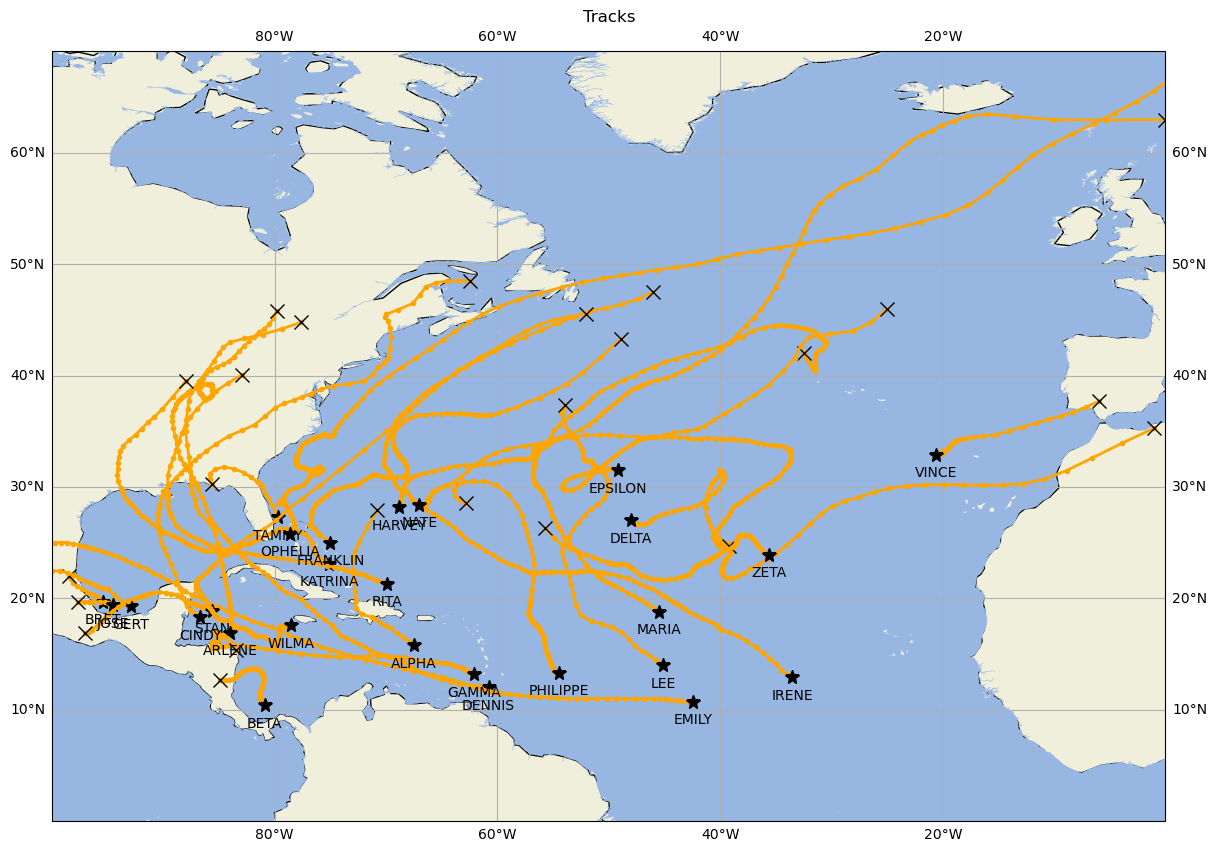

In [12]:
year=2005# Change this to see tracks from other years.
storms = storms_subset.where(storms_subset.season==year, drop=True)
#storms = tks.where(tks.season==year, drop=True) # select the hurricanes that happened in selected year
#print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Tracks")
# plt.legend()


## 2.3.2 Visualize hurricane destruction


most named hurricanes since 1980 cause limited destruction in terms of damage & lives lost. A relative few storms cause strong damage. Genearlly damage and deaths are positively correlated, with a wider range of destruction costs. Katrina & Harvey are outliers in lives lost

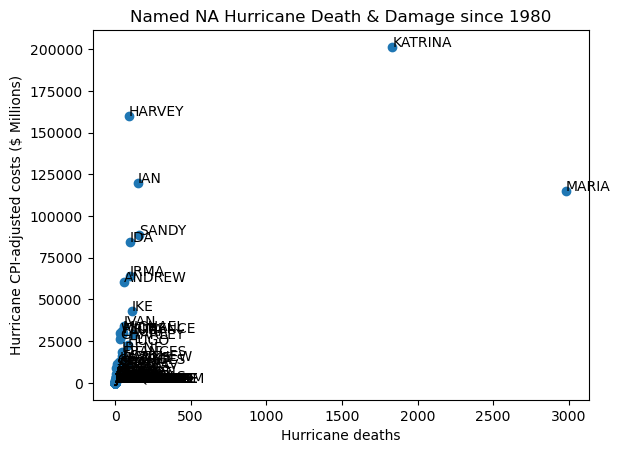

In [13]:
#scatter of deaths by CPI_adj_costs
fig, ax = plt.subplots()
ax.scatter(storms_subset.deaths, storms_subset.CPI_adj_costs)
ax.set_xlabel('Hurricane deaths')
ax.set_ylabel('Hurricane CPI-adjusted costs ($ Millions)')
ax.set_title('Named NA Hurricane Death & Damage since 1980')

for i, txt in enumerate(storms_subset.name.values):
    ax.annotate(txt, (storms_subset.deaths[i], storms_subset.CPI_adj_costs[i]))
plt.show()


\\

---

\\

# Step 3: Analyze Tracks

Here we use moment as a numerical characteristic of a track. [Ophelia (2005)](https://en.wikipedia.org/wiki/Hurricane_Ophelia_(2005)) is given as an example track.



## 3.1 Define the moments of a track

Below codes plot ONE track and its moments based on the paper's idea.

So, what we want to do here is to find a summary statistics for the track. Here the method below calculates the weighted first and second moments of a track, which would ouput a 5-entry vector which can be used in clustering and analysis purpose.

M1 here stands for the first moment. When the weights $w$ are set to 1, it simply calculating the means of the longitude and latitude vectors. Changing the weights to other variables, such as wind speed, storm speed, temperatures, etc. should result in different clustering. In the paper, setting all the weights to 1 is used.

M2 stands for the second moment. When the weights are 1, it is calculating the variances and covariance of longitude and latitude vectors of a given track.

$r$ is a two-dimensional vector that corresponds to $(x,y)$, i.e., longitude and latitude.

See [Nakamura et al (2009)](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) for more details on the notation.

$$
\begin{aligned}
\mathbf{M 1}&=\frac{1}{A} \int w(\mathbf{r}) \mathbf{r} d x d y=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right) \mathbf{r}_{i} \\
\mathbf{M 2} &=\frac{1}{A} \int w(\mathbf{r})(\mathbf{r}-\mathbf{M 1})^{2} d x d y
=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right)\left(\mathbf{r}_{i}-\mathbf{M 1}_{i}\right)^{2}
\end{aligned}
$$


## 3.1.1 Function to calculate moment for a system

This function outputs a length-5 vector that summaries the moments of a track as specified in the above description.


In [14]:
def get_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

In [15]:
def get_destruction(storm):
  CPI_adj_costs_lst = storm.CPI_adj_costs.values
  deaths_lst = storm.deaths.values
  return [CPI_adj_costs_lst, deaths_lst]

#km_destruction = get_destruction(

## 3.1.2 Calculate moments and visualize for one system

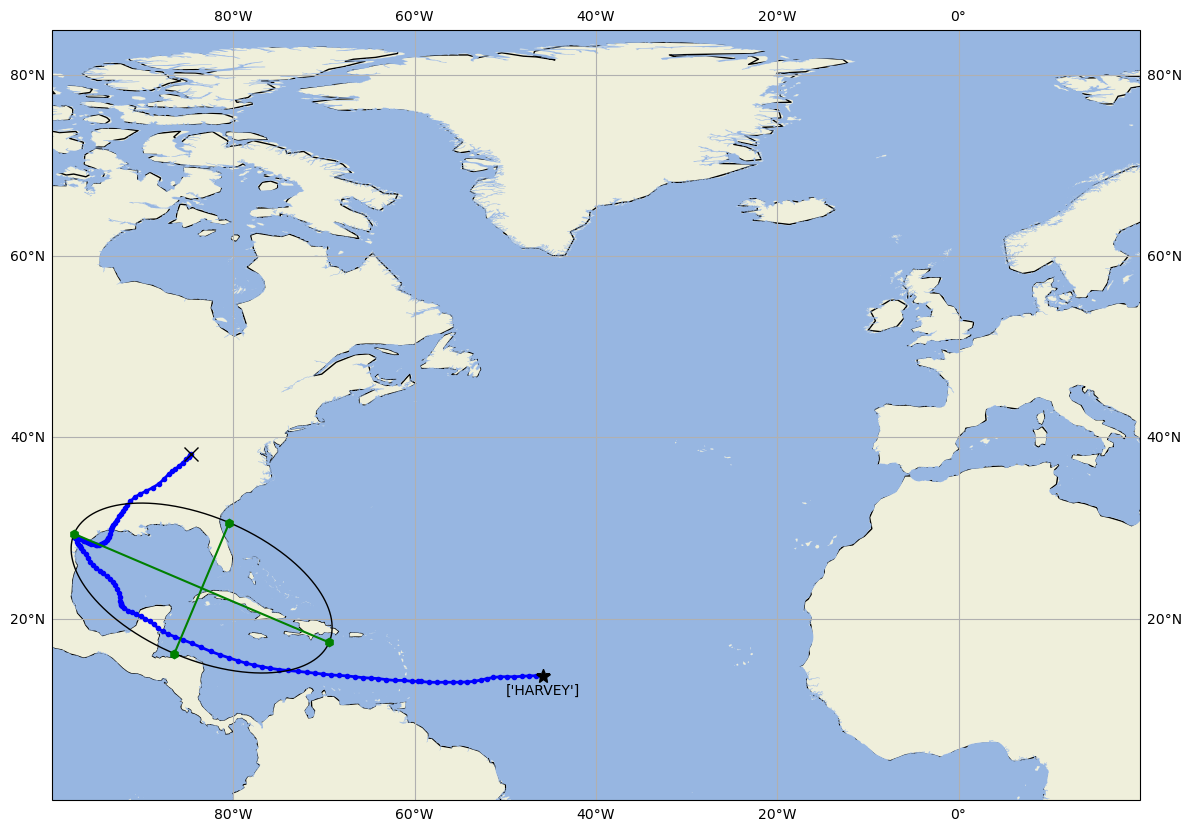

In [16]:
#storm_i = storms_subset.where(storms_subset.name=='HARVEY', drop=True)
storm_i = storms_subset.where((storms_subset.name=='HARVEY')&(storms_subset.season==2017), drop=True)
lon_weighted, lat_weighted, lon_var, lat_var, xy_var = get_moments(storm_i)

# Rotate the circle and calculate points on the circle
# Set N larger to make the oval more precise and to consume more electricity
N=1000
t = np.linspace(0, 2 * np.pi, N)
circle = [np.sqrt(lon_var) * np.cos(t), np.sqrt(lat_var) * np.sin(t)]
_, R_rot = LA.eig(np.array([[lon_var, xy_var], [xy_var, lat_var]]))
circle = np.dot(R_rot, circle)
R_1, R_2 = circle[0, :] + lon_weighted, circle[1, :] + lat_weighted

# Plot
ax = map_background(extent=[-100, 20, 0, 80], label=True)
plot_one_track(ax, storm_i)
ax.plot(R_1, R_2, '-', color='black', linewidth=1)
ax.plot([circle[0,0], circle[0,int(N/2)]]+lon_weighted,
        [circle[1,0], circle[1,int(N/2)]]+lat_weighted, '-gh')
ax.plot([circle[0,int(N/4)], circle[0,int(N*3/4)]]+lon_weighted,
        [circle[1,int(N/4)], circle[1,int(N*3/4)]]+lat_weighted, '-gh')

## 3.2 K-means clustering using moments for all systems

In this section, K-means clustering is carried out on the historical tracks with the idea adopted from the paper. As the data are different, nuances with the clustering results are expected.

In [17]:
#running clustering based on path (1st & 2nd moments) for named hurricanes since 1980
moment_lst = [get_moments(storms_subset.sel(storm=i)) for i in range(storms_subset.dims['storm'])
              if get_moments(storms_subset.sel(storm=i))]
#run for subset with just named storms

print(np.shape(moment_lst))
print(f"There are {storms_subset.dims['storm']-np.shape(moment_lst)[0]} tracks that have length less than 1.")

(581, 5)
There are 0 tracks that have length less than 1.


In [18]:
#running clustering based on destruction (deaths & damage costs) for named hurricanes since 1980 
destruction_lst = [get_destruction(storms_subset.sel(storm=i)) for i in range(storms_subset.dims['storm'])
              if get_destruction(storms_subset.sel(storm=i))]

lat_lon_lst = [get_lon_lat(storms_subset.sel(storm=i)) for i in range(storms_subset.dims['storm'])
              if get_lon_lat(storms_subset.sel(storm=i))]

### 3.2.1 Find inertia values to determine the right number of clusters

Run the clustering for a range of cluster numbers and extract the interia value

Inertia values from sklearn are evaluated with the "elbow method" to determine the optimal value of the clusters.\
Inertia, or cost, is calculated as the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. See the documentation for [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for more details.

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k (destruction)')

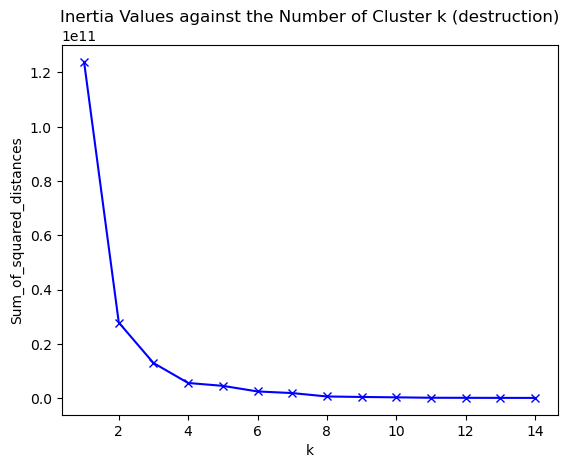

In [19]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    kmd = k_means(destruction_lst, n_clusters=k)
    sum_of_squares.append(kmd[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k (destruction)')
#even though 3 is the number determined from the elbow method, will increase to pickup more storms 

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

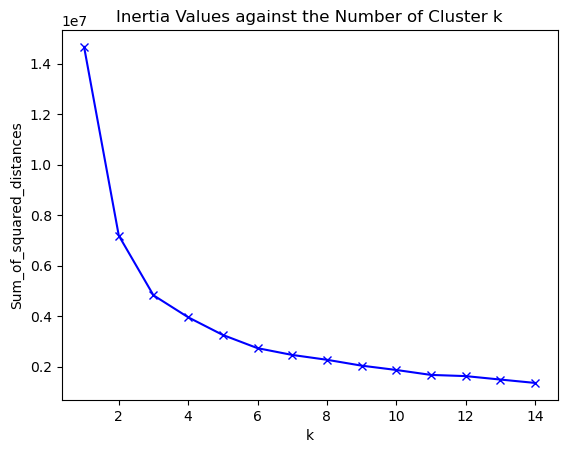

In [20]:
#running for since 1979

sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

#5 or six clusters, will keep with 6

From the plot above, 6 (4-6) & 3 are probably a good choice for the number of clusters for path & destruction clustering respectively.\
Below codes plot the K-means results. The locations on the map are the weighted first moment of the hurricane tracks. In the example code, the weights were set to be 1 meaning that the first moment is the sample mean (see section 3.1 description).

Note that if you run the code again the ordering of the clusters changes

### Run clusters & add to df

In [21]:
#k_means(destruction_lst)
km_d = k_means(destruction_lst, n_clusters=12)
#for storms since 1979, cluster based on path (1st and 2nd moment)
km = k_means(moment_lst, n_clusters=6)

In [22]:
#adding cluster information to df
dummy_var3 = np.zeros(len(storms_subset['name']))
storms_subset['cluster_path'] = (['storm'],  dummy_var3)

for i in range(len(km[1])):
    storms_subset.cluster_path[i] = km[1][i]
#    print(km[1][i], storms_subset.cluster_path.values[i])

dummy_var4 = np.zeros(len(storms_subset['name']))
storms_subset['one_moment'] = (['storm'],  dummy_var4)
dummy_var5 = np.zeros(len(storms_subset['name']))
storms_subset['two_moment'] = (['storm'],  dummy_var5)

for i in range(len(moment_lst)):
    storms_subset.one_moment[i] = moment_lst[i][0]
    storms_subset.two_moment[i] = moment_lst[i][1]

dummy_var6 = np.zeros(len(storms_subset['name']))
storms_subset['cluster_destruction'] = (['storm'],  dummy_var6)

for i in range(len(km_d[1])):
    storms_subset.cluster_destruction[i] = km_d[1][i]

#storms_subset

In [23]:
#hiding for now
#visualize data
#colors = ['black', 'red', 'blue']
#labels2 = km_d[1]

#ax = map_background()
#for k in range(len(storms_subset.name)):
#    ax.plot(storms_subset.one_moment.values[k], storms_subset.two_moment.values[k], c=colors[int(labels2[k])], marker='*')
#plt.title('K-means clustering result on destruction, 3 clusters')


Text(0.5, 1.0, 'K-means clustering result on path, 6 clusters')

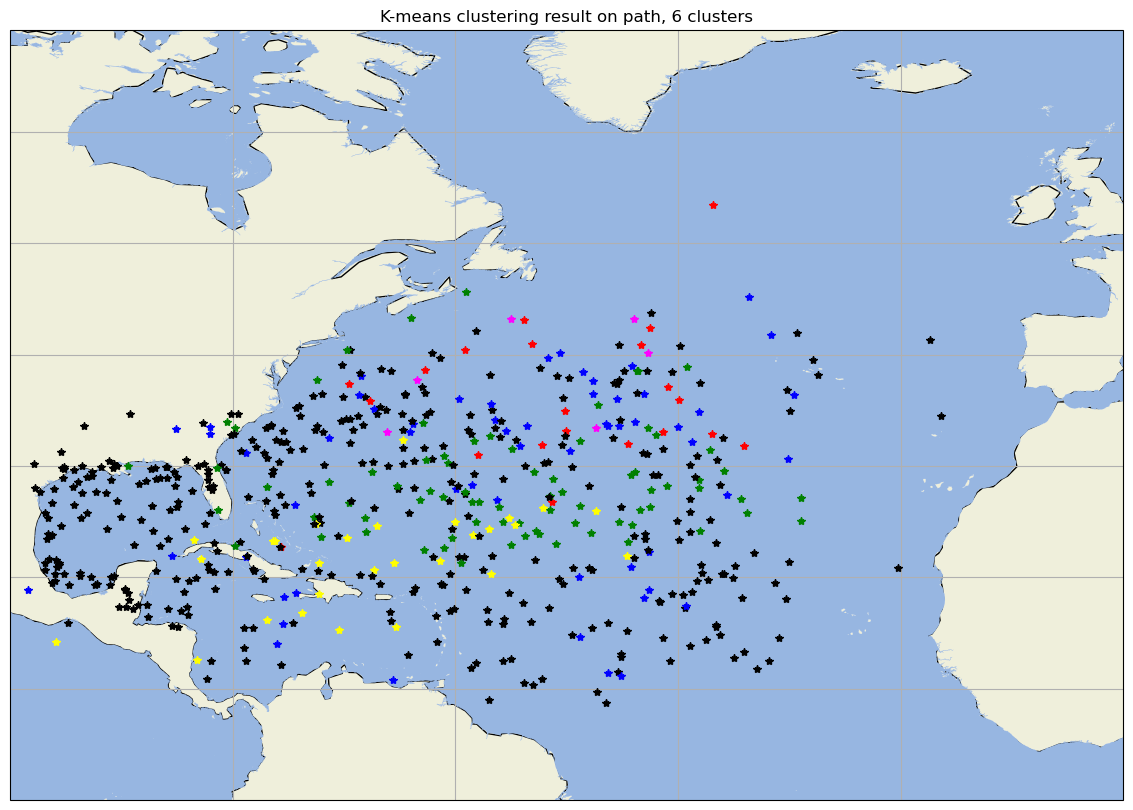

In [24]:
#same graph as in the paper, but with only named storms since 1980. Fairly similar clustering
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')

plt.title('K-means clustering result on path, 6 clusters')


Testing visuals for path & destruction (for now hidden)

In [25]:
#colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
#labels1 = storms_subset.cluster_path.values
#ax = map_background()
#for k in range(len(storms_subset.name)):
#    print(colors[labels[k]])
#    print(labels[k], int(labels1[k]))
#    ax.plot(storms_subset.one_moment.values[k], storms_subset.two_moment.values[k], c=colors[int(labels1[k])], marker='*', markersize=int(storms_subset.deaths.values[k])/25)
#    ax.plot(storms_subset.one_moment.values[k], storms_subset.two_moment.values[k], marker='*')
#plt.title('K-means clustering result weighing for destruction, 6 clusters')

## Visualize the clusturing by destruction 

Clustering groups storms based on damage

In [26]:
storms_subset

<xarray.Dataset> Size: 147MB
Dimensions:              (storm: 581, date_time: 360, quadrant: 4)
Coordinates:
    time                 (storm, date_time) float64 2MB ...
    lat                  (storm, date_time) float32 837kB ...
    lon                  (storm, date_time) float32 837kB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/153)
    numobs               (storm) float32 2kB 91.0 47.0 43.0 ... 31.0 49.0 106.0
    sid                  (storm) object 5kB b'1980214N11330' ... b'2023292N13...
    season               (storm) float32 2kB 1.98e+03 1.98e+03 ... 2.023e+03
    number               (storm) float32 2kB 57.0 62.0 63.0 ... 62.0 67.0 70.0
    basin                (storm, date_time) object 2MB b'NA' b'NA' ... b'' b''
    subbasin             (storm, date_time) object 2MB b'NA' b'NA' ... b'' b''
    ...                   ...
    CPI_adj_costs        (storm) float64 5kB 2.236e+03 0.0 0.0 ... 0.0 0.0 0.0
    deaths               (storm) float64 5kB 13.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cluster_path         (storm) float64 5kB 3.0 0.0 0.0 4.0 ... 0.0 0.0 0.0 0.0
    one_moment           (storm) float64 5kB -72.22 -38.92 ... -41.33 -57.9
    two_moment           (storm) float64 5kB 18.46 27.03 37.11 ... 14.53 23.75
    cluster_destruction  (storm) float64 5kB 9.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

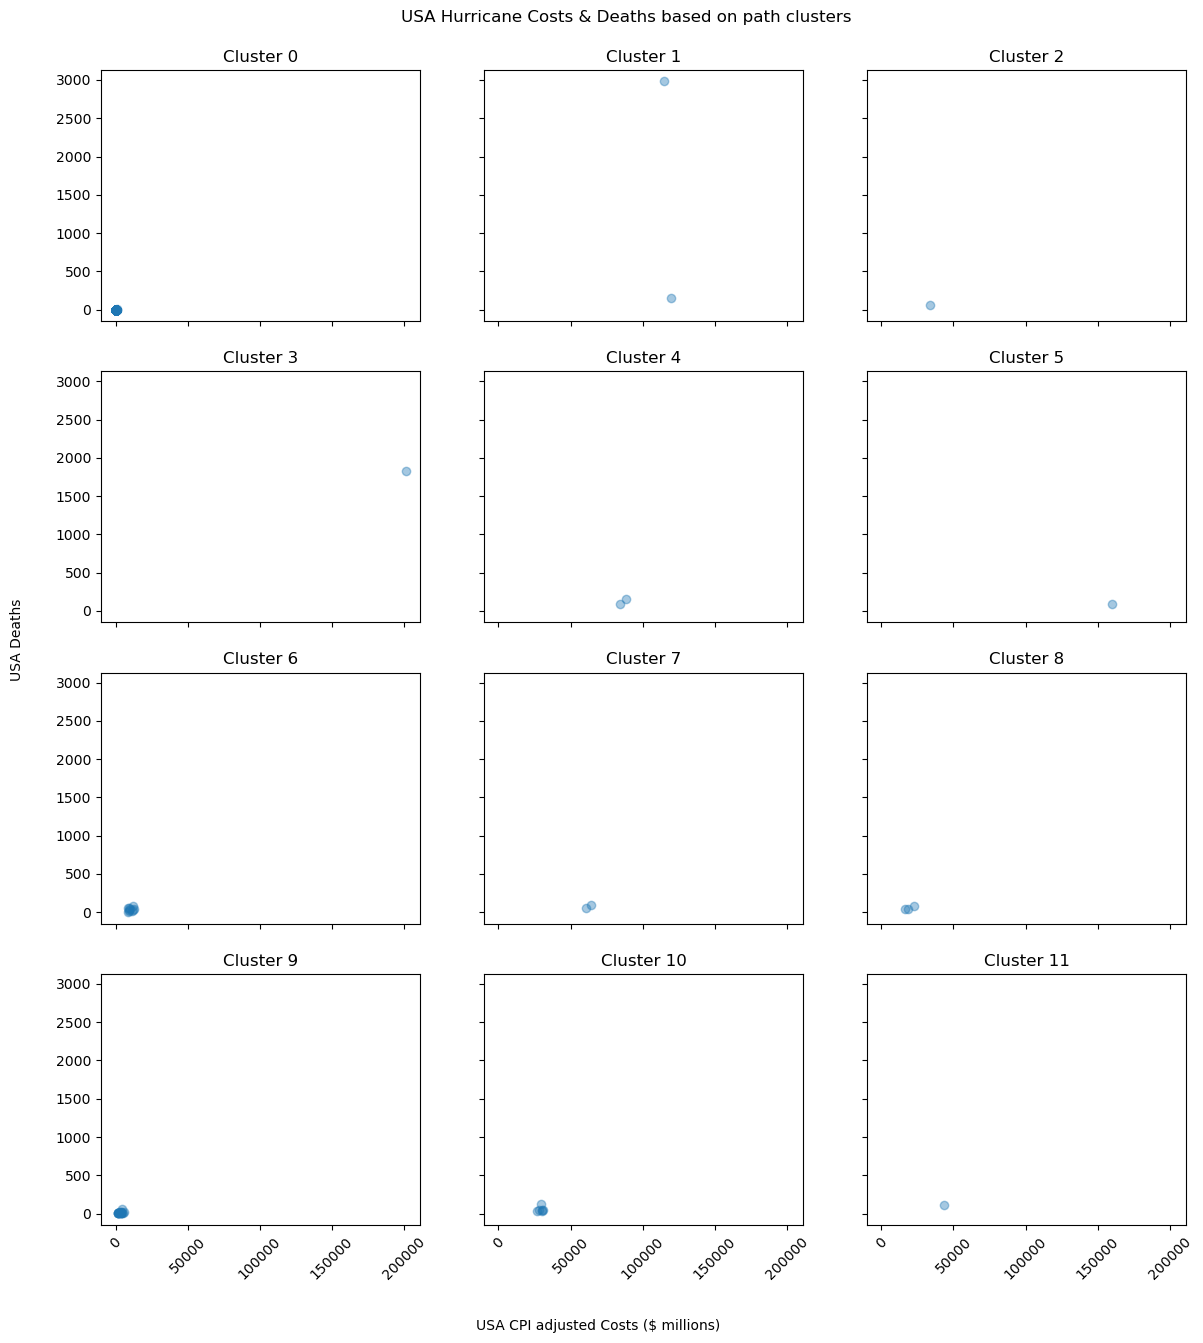

In [27]:
#fig, ax = plt.subplots(figsize=(12, 5),ncols=3, nrows=4, sharey=True)

unique_clusters = np.unique(storms_subset["cluster_destruction"].values)

fig, axes = plt.subplots(figsize=(14, 15),ncols=3, nrows=4, sharey=True, sharex=True)
axes = axes.flatten()
for i, cluster_id in enumerate(unique_clusters):
    ax = axes[i]
    cluster_storms = storms_subset.where(storms_subset.cluster_destruction == cluster_id, drop=True)
    ax.scatter(cluster_storms.CPI_adj_costs, cluster_storms.deaths, alpha=.4)
    ax.set_title(f"Cluster {i}")
    ax.tick_params('x', labelrotation=45)

#plt.tight_layout()
plt.suptitle('USA Hurricane Costs & Deaths based on path clusters',y=0.92)
fig.text(0.48, 0.04, 'USA CPI adjusted Costs ($ millions)', ha='center', fontsize=10)
fig.text(0.06, 0.5, 'USA Deaths', va='center', rotation='vertical', fontsize=10)
plt.show()

## Visualizing clustering based on path & destruction

There is some relationship between path and destruction
there exists low destruction across all of the path clusters, but higher destruction clusters are not found in all path clusters

will add 1st & 2nd moment to regression

<Axes: xlabel='cluster_path', ylabel='cluster_destruction'>

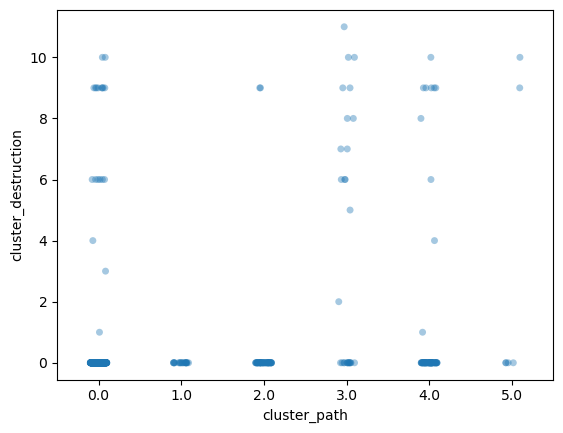

In [28]:
#importing seaborn to plat jittered scatter
import seaborn as sns
sns.stripplot(x = storms_subset.cluster_path, y = storms_subset.cluster_destruction, jitter = True, alpha = .4, edgecolor='none')


In [29]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(storms_subset.cluster_path, storms_subset.cluster_destruction)
print("Spearman's Rho:", rho)
print("P-value:", p_value)

Spearman's Rho: 0.19166379970110087
P-value: 3.2696562383456e-06


In [30]:
#find the lowest cluster_destruction
grouped = storms_subset.deaths.groupby(storms_subset.cluster_destruction)
grouped_min = storms_subset.deaths.groupby(storms_subset.cluster_destruction).mean().min()
min = grouped.mean() == grouped_min
min_cluster = np.where(min)[0]
print(min_cluster)

[0]


Text(0.5, 1.0, 'Path of USA Damaging Storms')

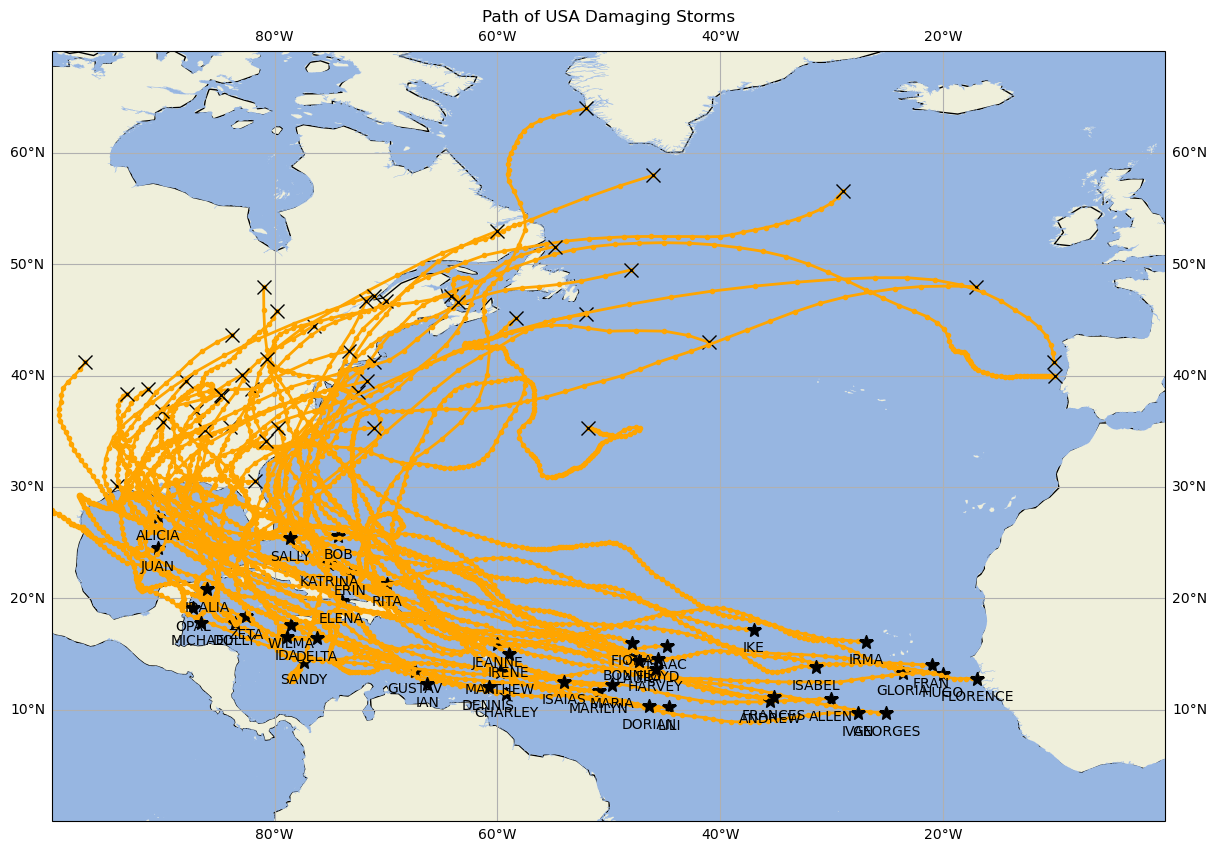

In [31]:
#clusterd=0# Change this to see tracks from other years.
storms = storms_subset.where(storms_subset.cluster_destruction!=min_cluster, drop=True)
#storms = tks.where(tks.season==year, drop=True) # select the hurricanes that happened in selected year
#print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Path of USA Damaging Storms")
# plt.legend()

In [32]:
#47 storms with damage
storms

<xarray.Dataset> Size: 12MB
Dimensions:              (storm: 47, date_time: 360, quadrant: 4)
Coordinates:
    time                 (storm, date_time) float64 135kB ...
    lat                  (storm, date_time) float32 68kB ...
    lon                  (storm, date_time) float32 68kB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/153)
    numobs               (storm) float32 188B 91.0 48.0 64.0 ... 74.0 104.0
    sid                  (storm) object 376B b'1980214N11330' ... b'2023239N2...
    season               (storm) float32 188B 1.98e+03 1.983e+03 ... 2.023e+03
    number               (storm) float32 188B 57.0 47.0 79.0 ... 31.0 35.0 46.0
    basin                (storm, date_time) object 135kB b'NA' b'NA' ... b'' b''
    subbasin             (storm, date_time) object 135kB b'NA' b'NA' ... b'' b''
    ...                   ...
    CPI_adj_costs        (storm) float64 376B 2.236e+03 9.45e+03 ... 3.56e+03
    deaths               (storm) float64 376B 13.0 21.0 4.0 ... 25.0 152.0 5.0
    cluster_path         (storm) float64 376B 3.0 0.0 0.0 4.0 ... 4.0 0.0 2.0
    one_moment           (storm) float64 376B -72.22 -95.42 ... -78.7 -71.34
    two_moment           (storm) float64 376B 18.46 31.26 28.92 ... 21.93 32.52
    cluster_destruction  (storm) float64 376B 9.0 6.0 9.0 9.0 ... 9.0 1.0 9.0
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

## working on adding state & county info based on lat & lon

In [33]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="geoapiExercises")

In [34]:
# #miami_test = [25.5516, 80.6327]
# def get_state(latitude, longitude):
#     geolocator = Nominatim(user_agent="your_app_name")
#     lon = -abs(longitude)
#     location = geolocator.reverse((latitude, lon), exactly_one=True)
#     if location:
#         address = location.raw['address']
#         state = address.get('state', '')
# #        county = address.get('county', '')
#         return state
#     return None
    
# def get_county(latitude, longitude):
#     geolocator = Nominatim(user_agent="your_app_name")
#     lon = -abs(longitude)
#     location = geolocator.reverse((latitude, lon), exactly_one=True)
#     if location:
#         address = location.raw['address']
# #        state = address.get('state', '')
#         county = address.get('county', '')
#         return county
#     return None

# latitude = 25.5516  # Example latitude
# longitude = 80.6327  # Example longitude

# state = get_state(latitude, longitude)
# county = get_county(latitude, longitude)
# print(state, county) 


In [35]:
#storms_subset.
#.isel(time=-1)
#(lon=300, lat=50)
#test_subset = storms_subset.isel(lon=0, lat=0)
#test_subset

# References

+ Nakamura, Jennifer, et al. "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml).

+ Nakamura, Jennifer, et al. "Western North Pacific tropical cyclone model tracks in present and future climates." Journal of Geophysical Research: Atmospheres 122.18 (2017): [9721-9744](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JD027007).

# States & Counties

In [36]:
import geopandas as gpd
from shapely.geometry import Point

# Load state and county shapefiles
states_gdf = gpd.read_file("data/cb_2023_us_state_5m.shp")  # State boundaries
counties_gdf = gpd.read_file("data/cb_2023_us_county_5m.shp")  # County boundaries
us_boundary = gpd.read_file("data/cb_2023_us_nation_5m.shp")  # U.S. boundary

# Ensure all geometries use the same coordinate reference system (CRS)
states_gdf = states_gdf.to_crs(epsg=4326)
counties_gdf = counties_gdf.to_crs(epsg=4326)
us_boundary = us_boundary.to_crs(epsg=4326)  # U.S. national boundary

# Function to get state and county for U.S. landfall points
def get_state_county(lat, lon):
    point = Point(lon, lat)

    # Check if the point is inside the U.S.
    if not us_boundary.contains(point).any():
        return np.nan, np.nan  # Skip non-U.S. points

    # Find the state
    state_match = states_gdf[states_gdf.contains(point)]
    state_name = state_match["NAME"].values[0] if not state_match.empty else None

    # Find the county
    county_match = counties_gdf[counties_gdf.contains(point)]
    county_name = county_match["NAME"].values[0] if not county_match.empty else None

    return state_name, county_name

In [37]:
# Convert storms dataset to structured NumPy arrays
dist2land_vals = storms["dist2land"].values
lat_vals = storms["lat"].values
lon_vals = storms["lon"].values

# Find landfall indices (where dist2land == 0)
landfall_indices = np.where(np.isclose(dist2land_vals, 0))

# Create empty arrays for state and county values
state_var = np.full_like(dist2land_vals, np.nan, dtype=object)
county_var = np.full_like(dist2land_vals, np.nan, dtype=object)

# Compute state and county only for landfall points inside the U.S.
for i, j in zip(*landfall_indices):
    lat, lon = lat_vals[i, j], lon_vals[i, j]

    state, county = get_state_county(lat, lon)

    state_var[i, j] = state
    county_var[i, j] = county

# Add results to the storms dataset
storms["landfall_state"] = (("storm", "date_time"), state_var)
storms["landfall_county"] = (("storm", "date_time"), county_var)

storms

<xarray.Dataset> Size: 12MB
Dimensions:              (storm: 47, date_time: 360, quadrant: 4)
Coordinates:
    time                 (storm, date_time) float64 135kB ...
    lat                  (storm, date_time) float32 68kB 11.0 10.95 ... nan nan
    lon                  (storm, date_time) float32 68kB -30.0 -31.11 ... nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/155)
    numobs               (storm) float32 188B 91.0 48.0 64.0 ... 74.0 104.0
    sid                  (storm) object 376B b'1980214N11330' ... b'2023239N2...
    season               (storm) float32 188B 1.98e+03 1.983e+03 ... 2.023e+03
    number               (storm) float32 188B 57.0 47.0 79.0 ... 31.0 35.0 46.0
    basin                (storm, date_time) object 135kB b'NA' b'NA' ... b'' b''
    subbasin             (storm, date_time) object 135kB b'NA' b'NA' ... b'' b''
    ...                   ...
    cluster_path         (storm) float64 376B 3.0 0.0 0.0 4.0 ... 4.0 0.0 2.0
    one_moment           (storm) float64 376B -72.22 -95.42 ... -78.7 -71.34
    two_moment           (storm) float64 376B 18.46 31.26 28.92 ... 21.93 32.52
    cluster_destruction  (storm) float64 376B 9.0 6.0 9.0 9.0 ... 9.0 1.0 9.0
    landfall_state       (storm, date_time) object 135kB nan nan nan ... nan nan
    landfall_county      (storm, date_time) object 135kB nan nan nan ... nan nan
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

# Intensity

In [149]:
# Calculate the PDI, which considers both max wind speed and life span

# Convert wind speed from knots to meters per second
wind_mps = storms.usa_wind.values * 0.514444

# Initialize an array for storing PDI values
pdi_values = np.full(storms.dims["storm"], np.nan)  # One value per storm

# Loop over each storm
for i in range(storms.dims["storm"]):
    # Extract wind and time data for this storm
    wind_series = wind_mps[i, :]
    time_series = storms.iso_time.values[i, :]

    # Convert time from bytes to datetime, replacing empty values (b'') with NaT
    time_series = np.array([
        pd.to_datetime(t.decode("utf-8")) if isinstance(t, bytes) and t and t.decode("utf-8") else pd.NaT
        for t in time_series
    ])

    # Create a mask for valid wind and time values
    valid_mask = (~np.isnan(wind_series)) & pd.notna(time_series)

    # Filter out invalid values
    valid_wind = wind_series[valid_mask]
    valid_time = time_series[valid_mask]

    # Skip if there are fewer than 2 valid data points
    if len(valid_wind) < 2:
        continue

    # Compute time differences in seconds
    time_deltas = np.diff(valid_time).astype('timedelta64[s]').astype(float)  # Convert to seconds

    # Ensure no negative or NaN time differences
    time_deltas = np.maximum(time_deltas, 0)
    
    # Compute cumulative time in seconds
    cumulative_time = np.cumsum(time_deltas)  # Ensure time is monotonically increasing

    # Compute wind speed cubed
    wind_cubed = valid_wind[:-1] ** 3  # Exclude last point to match `time_deltas`

    # Perform numerical integration using trapezoidal rule
    pdi = np.trapz(wind_cubed, cumulative_time)

    # Scale PDI values and store the result
    pdi_values[i] = pdi * 1e-11

# Add PDI (Intensity) to the storms dataset
storms["Intensity"] = (("storm",), pdi_values)

In [150]:
storms.Intensity

<xarray.DataArray 'Intensity' (storm: 47)> Size: 376B
array([2.00805018, 0.14534566, 0.42579681, 0.60499401, 0.14585182,
       1.38505281, 0.20929306, 0.9426401 , 0.14547493, 0.54071287,
       0.30779832, 0.56382412, 0.6455121 , 1.10960896, 0.89003018,
       0.41771215, 2.20681222, 0.28280938, 1.40932425, 2.5260452 ,
       0.54619372, 0.5671988 , 0.64572627, 0.86639369, 1.36168708,
       0.09627108, 0.47837124, 1.11558239, 0.45381746, 0.17209044,
       0.31969877, 1.74804985, 0.26747925, 2.38245127, 1.39351534,
       1.09395591, 0.45842616, 1.66155835, 0.1900838 , 0.33954256,
       0.15375194, 0.40985626, 0.15757226, 0.32306851, 0.86145519,
       0.50116595, 0.26145494])
Dimensions without coordinates: storm

# Population

In [151]:
def interpolate_and_extrapolate_population_data(df):
    # Define the range of years from 1980 to 2024
    years = list(range(1980, 2025))
    
    new_df = pd.DataFrame()
    new_df['cty_fips'] = df['cty_fips']
    new_df['cty'] = df['cty']
    
    for year in years:
        if year in df.columns:  # If exact year data exists
            new_df[f'{year}.0'] = df[f'pop_{year}']
        elif year < 2020:  # Interpolation for years between decades
            lower_decade = (year // 10) * 10
            upper_decade = lower_decade + 10

            pop_lower = df[f'pop_{lower_decade}']
            pop_upper = df[f'pop_{upper_decade}']

            weight_upper = (year - lower_decade) / 10
            weight_lower = 1 - weight_upper

            new_df[f'{year}.0'] = (pop_lower * weight_lower + 
                                 pop_upper * weight_upper).round().astype(int)
        else:  # Extrapolation for 2021-2024
            pop_2010 = df['pop_2010']
            pop_2020 = df['pop_2020']
            
            # Compute annual growth rate based on 2010-2020 trend
            annual_growth_rate = (pop_2020 - pop_2010) / 10
            
            # Estimate future population
            new_df[f'{year}.0'] = (pop_2020 + (year - 2020) * annual_growth_rate).round().astype(int)

    year_cols = [str(f'{year}.0') for year in years]
    new_df = new_df[['cty_fips', 'cty'] + year_cols]
    
    return new_df

# Load data and apply function
df = pd.read_csv('data/historical_county_populations_v2.csv')
extrapolated_df = interpolate_and_extrapolate_population_data(df)
extrapolated_df

,cty_fips,cty,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
0,1001,"Autauga County, Alabama",32259,32455,32652,32848,33044,33240,33437,33633,...,56688,57111,57535,57958,58382,58805,59228,59652,60075,60499
1,1003,"Baldwin County, Alabama",78556,80528,82501,84473,86446,88418,90390,92363,...,207016,211966,216916,221867,226817,231767,236717,241667,246618,251568
2,1005,"Barbour County, Alabama",24756,24822,24888,24954,25020,25086,25153,25219,...,26340,26117,25893,25670,25446,25223,25000,24776,24553,24329
3,1007,"Bibb County, Alabama",15723,15808,15894,15979,16064,16150,16235,16320,...,22604,22542,22480,22417,22355,22293,22231,22169,22106,22044
4,1009,"Blount County, Alabama",36459,36738,37017,37296,37575,37854,38132,38411,...,58228,58409,58590,58772,58953,59134,59315,59496,59678,59859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,27129,"Renville County, Minnesota",20401,20128,19855,19583,19310,19037,18764,18491,...,15226,15126,15025,14924,14824,14723,14622,14522,14421,14320
3128,27135,"Roseau County, Minnesota",12574,12819,13064,13310,13555,13800,14045,14290,...,15480,15450,15420,15391,15361,15331,15301,15271,15242,15212
3129,27141,"Sherburne County, Minnesota",29908,31112,32315,33519,34723,35926,37130,38334,...,92841,93709,94578,95446,96315,97183,98051,98920,99788,100657
3130,27147,"Steele County, Minnesota",30328,30368,30408,30448,30488,30528,30569,30609,...,36991,37074,37157,37240,37323,37406,37489,37572,37655,37738


In [152]:
extrapolated_df['State'] = interpolated_df.cty.str.split().str[-1]
extrapolated_df['County'] = interpolated_df.cty.str.split().str[0]
extrapolated_df

,cty_fips,cty,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,State,County
0,1001,"Autauga County, Alabama",32259,32455,32652,32848,33044,33240,33437,33633,...,57535,57958,58382,58805,59228,59652,60075,60499,Alabama,Autauga
1,1003,"Baldwin County, Alabama",78556,80528,82501,84473,86446,88418,90390,92363,...,216916,221867,226817,231767,236717,241667,246618,251568,Alabama,Baldwin
2,1005,"Barbour County, Alabama",24756,24822,24888,24954,25020,25086,25153,25219,...,25893,25670,25446,25223,25000,24776,24553,24329,Alabama,Barbour
3,1007,"Bibb County, Alabama",15723,15808,15894,15979,16064,16150,16235,16320,...,22480,22417,22355,22293,22231,22169,22106,22044,Alabama,Bibb
4,1009,"Blount County, Alabama",36459,36738,37017,37296,37575,37854,38132,38411,...,58590,58772,58953,59134,59315,59496,59678,59859,Alabama,Blount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,27129,"Renville County, Minnesota",20401,20128,19855,19583,19310,19037,18764,18491,...,15025,14924,14824,14723,14622,14522,14421,14320,Minnesota,Renville
3128,27135,"Roseau County, Minnesota",12574,12819,13064,13310,13555,13800,14045,14290,...,15420,15391,15361,15331,15301,15271,15242,15212,Minnesota,Roseau
3129,27141,"Sherburne County, Minnesota",29908,31112,32315,33519,34723,35926,37130,38334,...,94578,95446,96315,97183,98051,98920,99788,100657,Minnesota,Sherburne
3130,27147,"Steele County, Minnesota",30328,30368,30408,30448,30488,30528,30569,30609,...,37157,37240,37323,37406,37489,37572,37655,37738,Minnesota,Steele


In [153]:
# Convert storms dataset to a pandas DataFrame for easier processing
storms_df = storms.to_dataframe().reset_index()
storms_df['season'] = storms_df['season'].astype(str)  # Ensure season is a string
storms_df['population'] = np.nan 

# Iterate over each unique storm
for storm in storms_df['storm'].unique():
    # Retrieve the season (year) and affected counties for the current storm
    season = storms_df.loc[storms_df['storm'] == storm, 'season'].values[0]
    counties = storms_df.loc[storms_df['storm'] == storm, 'landfall_county'].dropna().unique()  # Get unique counties

    # Ensure the season corresponds to a column in extrapolated_df
    if season in extrapolated_df.columns:
        total_population = extrapolated_df.loc[extrapolated_df['County'].isin(counties), season].sum()
        storms_df.loc[storms_df['storm'] == storm, 'population'] = total_population

# Convert the DataFrame back to an xarray Dataset
storms_updated = storms.copy()
storms_updated['population'] = (('storm',), storms_df.groupby('storm')['population'].first().values)

# View a subset of the results
storms_df[['storm', 'name', 'season', 'population', 'Intensity', 'CPI_adj_costs', 'deaths']].drop_duplicates()

,storm,name,season,population,Intensity,CPI_adj_costs,deaths
0,0,ALLEN,1980.0,406031.0,2.008050,2236.2,13.0
1440,1,ALICIA,1983.0,5031726.0,0.145346,9450.0,21.0
2880,2,ELENA,1985.0,10297395.0,0.425797,3788.4,4.0
4320,3,GLORIA,1985.0,852490.0,0.604994,2491.3,11.0
5760,4,JUAN,1985.0,6587027.0,0.145852,4340.4,63.0
7200,5,HUGO,1989.0,1376356.0,1.385053,22679.7,86.0
8640,6,BOB,1991.0,2200771.0,0.209293,3471.8,18.0
10080,7,ANDREW,1992.0,6953630.0,0.942640,60480.0,61.0
11520,8,ERIN,1995.0,8804953.0,0.145475,1751.0,6.0
12960,9,MARILYN,1995.0,0.0,0.540713,4326.0,13.0


#### for storm 34, it passed by Puerto Rico, of which population data is missing